In [1]:
import numpy as np

x=np.load("variables/x.npy")
y=np.load("variables/y.npy")
x_train=np.load("variables/x_train.npy")
x_test=np.load("variables/x_test.npy")
y_test=np.load("variables/y_test.npy")
y_train=np.load("variables/y_train.npy")

### C-Support Vector Classification (SVC)

In [2]:
from sklearn.svm import SVC

svc_clf = SVC(kernel="rbf")
svc_clf.fit(x_train,y_train)

SVC()

In [3]:
svc_clf.score(x_test,y_test)

0.9047619047619048

### VALIDATION CROISÉE :

In [4]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
svc_clf_scores = cross_val_score(svc_clf, x, 
                                      y, cv=10, scoring="f1")
display_scores(svc_clf_scores)

Scores: [0.73684211 0.71929825 0.69090909 0.66055046 0.77586207 0.66666667
 0.68468468 0.77310924 0.72566372 0.66055046]
Mean: 0.7094136740045982
Standard deviation: 0.04140420152754297


### GridSearchCV
Afin de trouver les meilleurs paramètres, nous allons utiliser la méthode d'optimisation GridSearchCV.

In [5]:
from sklearn.model_selection import GridSearchCV

svc_clf_param_grid = {'C':[1.0, 0.1, 0.01],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

grid_search_svc = GridSearchCV(svc_clf, svc_clf_param_grid, cv=10,
                           scoring='f1', return_train_score=True)
grid_search_svc.fit(x, y)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [1.0, 0.1, 0.01],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             return_train_score=True, scoring='f1')

In [6]:
grid_search_svc.best_params_

{'C': 1.0, 'gamma': 1, 'kernel': 'rbf'}

In [7]:
best_svc_clf = grid_search_svc.best_estimator_

In [8]:
%%capture --no-display
best_svc_clf_score = cross_val_score(best_svc_clf, x, 
                                          y, cv=10, scoring="f1")

In [9]:
display_scores(best_svc_clf_score)

Scores: [0.9929078  0.9929078  1.         0.9929078  0.98571429 1.
 0.98571429 1.         0.98571429 1.        ]
Mean: 0.9935866261398176
Standard deviation: 0.005931518333574744


 ### Matrice de Confusion
 
Nous allons maintenant utiliser afin d'étudier les performances de notre système de classification supervisé. Calculons maintenant cette matrice avec notre modèle amélioré.

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(svc_clf, x_train, y_train, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[2932,   24],
       [ 344,  228]], dtype=int64)

In [12]:
y_train_perfect_predictions = y_train
confusion_matrix(y_train, y_train_perfect_predictions)

array([[2956,    0],
       [   0,  572]], dtype=int64)

### Recall et precision en fonction du seuil
Affichons les valeurs du recall et de la précision en fonction du seuil ainsi que la valeur de la précision en fonction du recall

In [13]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred)

0.9047619047619048

In [14]:
recall_score(y_train, y_train_pred)

0.3986013986013986

In [15]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.5533980582524272

In [16]:
y_scores = cross_val_predict(svc_clf, x_train, y_train, cv=3,
                             method="decision_function")

In [17]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

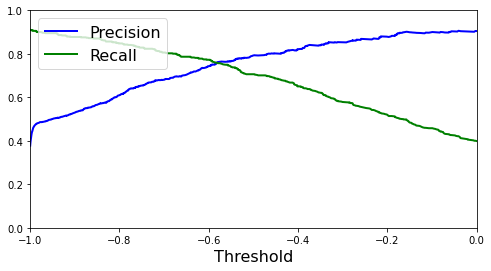

In [18]:
from matplotlib import pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-1, 0])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

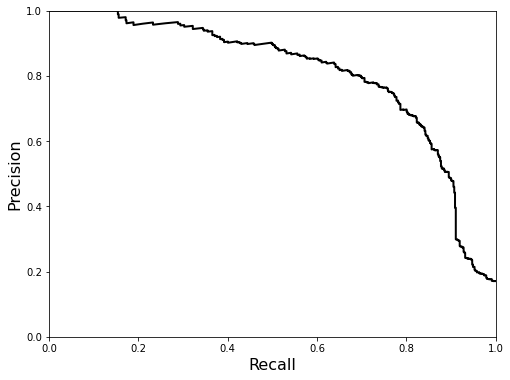

In [19]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "k-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

 ### Courbe ROC
 Affichons la courbe roc afin de confronter notre taux de vrai positif par rapport au taux de faux positif. plus la courbe se rapproche du coin supérieur gauche, plus notre taux de vrai positif est idéal, et on évite un maximum de faux positif. On utilise l'air sous la courbe ROC afin de comparer nos modèles, qui doit être le plus proche de 1.

In [20]:
from sklearn.metrics import roc_curve

fpr_svc, tpr_svc, thresholds = roc_curve(y_train, y_scores)

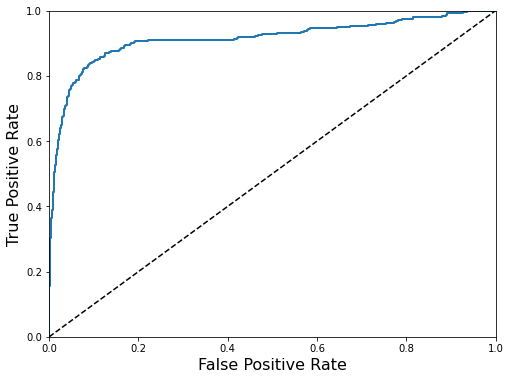

In [21]:
def plot_roc_curve(fpr_svc, tpr_svc, label=None):
    plt.plot(fpr_svc, tpr_svc, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_svc, tpr_svc)
#save_fig("roc_curve_plot")
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score 

roc_auc_score(y_train, y_scores) 

0.9141759796360609

In [24]:
np.save('variables/fpr_svc.npy', fpr_svc)
np.save('variables/tpr_svc.npy', tpr_svc)